# Курс "Алгортимы анализа данных"

## Практическое задание урока 3. Логистическая регрессия. Log Loss

Определите AUC_ROC и AUC_PR для построенной модели на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.(см. ipynb файл)

#### Генерируем данные

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

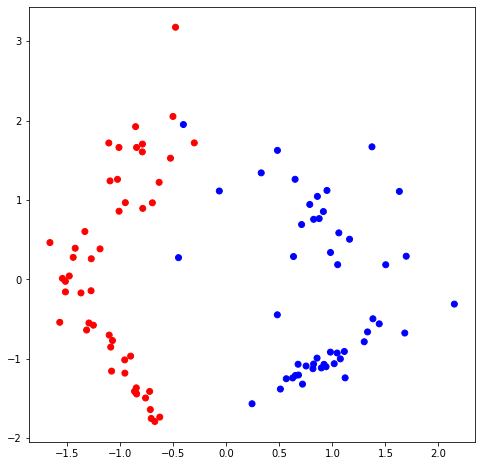

In [2]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

#### Реализация логистической регрессии

In [3]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


In [4]:
class logistic:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    @classmethod
    def log_loss(cls, w, X, y):
        m = X.shape[0]
        y=y[:, np.newaxis]
        # используем функцию сигмоиды, написанную ранее
        A = cls.sigmoid(np.dot(X, w.T))
        loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
        grad = 1.0 / m * np.dot((A - y).T, X)
        return loss, grad
    @classmethod
    def optimize(cls, w, X, y, n_iterations, eta):
        #     потери будем записывать в список для отображения в виде графика
        losses = []
        for i in range(n_iterations):        
            loss, grad = cls.log_loss(w, X, y)
            w = w - eta * grad
            losses.append(loss)
        return w, losses
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=0.05
    def fit(self, X, y):
        w0 = np.zeros((1, X.shape[1]))
        self.w, self.losses = self.optimize(w0, X, y, self.n_iterations, self.eta)
    def predict_proba(self, X):
        y_predicted = np.zeros(X.shape[0])    
        return self.sigmoid(np.dot(X, self.w.T)).flatten()
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

In [5]:
mod=logistic()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[3.72659902 0.22383415]]
Точность на обучающей выборке: 98.571
Точность на тестовой выборке: 96.667


#### Матрица ошибок

In [6]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [7]:
for thr in np.arange(0, 1.1, 0.1):
    print(f"Для порога по вероятности {thr:.1f}" + " на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, thr), y_test)}")

Для порога по вероятности 0.0 на тестовой выборке имеем: {'TP': 16, 'FP': 14, 'FN': 0, 'TN': 0}
Для порога по вероятности 0.1 на тестовой выборке имеем: {'TP': 16, 'FP': 3, 'FN': 0, 'TN': 11}
Для порога по вероятности 0.2 на тестовой выборке имеем: {'TP': 16, 'FP': 2, 'FN': 0, 'TN': 12}
Для порога по вероятности 0.3 на тестовой выборке имеем: {'TP': 15, 'FP': 1, 'FN': 1, 'TN': 13}
Для порога по вероятности 0.4 на тестовой выборке имеем: {'TP': 15, 'FP': 0, 'FN': 1, 'TN': 14}
Для порога по вероятности 0.5 на тестовой выборке имеем: {'TP': 15, 'FP': 0, 'FN': 1, 'TN': 14}
Для порога по вероятности 0.6 на тестовой выборке имеем: {'TP': 15, 'FP': 0, 'FN': 1, 'TN': 14}
Для порога по вероятности 0.7 на тестовой выборке имеем: {'TP': 14, 'FP': 0, 'FN': 2, 'TN': 14}
Для порога по вероятности 0.8 на тестовой выборке имеем: {'TP': 14, 'FP': 0, 'FN': 2, 'TN': 14}
Для порога по вероятности 0.9 на тестовой выборке имеем: {'TP': 10, 'FP': 0, 'FN': 6, 'TN': 14}
Для порога по вероятности 1.0 на тестово

**Receive Operating Characteristic:**

Чувствительность
(Sensitivity, TPR)= TP/(TP+FN)

Ложно-позитивный уровень
(FPR)=FP/(FP+TN)

In [38]:
TPR = []
FPR = []

for thr in np.arange(1.0, -0.05, -0.1):
    tpr = confusion(mod.predict(X_test, thr), y_test)['TP'] / \
    ( confusion(mod.predict(X_test, thr), y_test)['TP'] + 
     confusion(mod.predict(X_test, thr), y_test)['FN'] )
    
    TPR.append(tpr)
    
    fpr = confusion(mod.predict(X_test, thr), y_test)['FP'] / \
    ( confusion(mod.predict(X_test, thr), y_test)['FP'] + \
     confusion(mod.predict(X_test, thr), y_test)['TN'] )
    
    FPR.append(fpr)

print('TPR:', TPR)
print('FPR:', FPR)

TPR: [0.0, 0.625, 0.875, 0.875, 0.9375, 0.9375, 0.9375, 0.9375, 1.0, 1.0, 1.0]
FPR: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07142857142857142, 0.14285714285714285, 0.21428571428571427, 1.0]


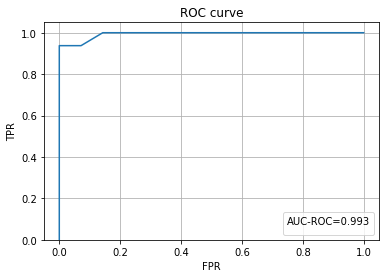

In [39]:
from numpy import trapz  # используем эту функцию для расчета площади под кривой

AUC_ROC = trapz(TPR, x = FPR, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

**Precision-Recall:**

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

In [40]:
precision = []
recall = []

for thr in np.arange(1, -0.05, -0.1):
    
    sd = confusion(mod.predict(X_test, thr), y_test)['TP'] + \
     confusion(mod.predict(X_test, thr), y_test)['FP']
    
    if sd == 0:
        pre = 0
    else:
        pre = confusion(mod.predict(X_test, thr), y_test)['TP'] / \
        ( confusion(mod.predict(X_test, thr), y_test)['TP'] + \
         confusion(mod.predict(X_test, thr), y_test)['FP'] )
    
    precision.append(pre)
    
    rec = confusion(mod.predict(X_test, thr), y_test)['TP'] / \
    ( confusion(mod.predict(X_test, thr), y_test)['TP'] + 
     confusion(mod.predict(X_test, thr), y_test)['FN'] )
    
    recall.append(rec)

print('Precision:', precision)
print('Recall:', recall)

Precision: [0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9375, 0.8888888888888888, 0.8421052631578947, 0.5333333333333333]
Recall: [0.0, 0.625, 0.875, 0.875, 0.9375, 0.9375, 0.9375, 0.9375, 1.0, 1.0, 1.0]


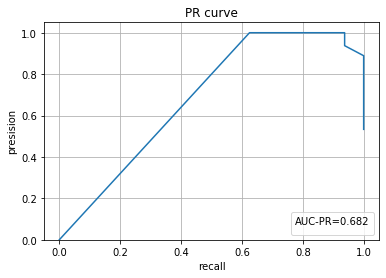

In [41]:
AUC_PR = trapz(precision, x = recall, dx=0.1)

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall, precision)